# Data Preprocess

## 1. Dataset Preparation

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import random
import datetime as dt
import gc

import seaborn as sns
import matplotlib.pyplot as plt

color = sns.color_palette()
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

np.random.seed(1)

In [2]:
# load the dataset
train = pd.read_csv('../dataset/raw/train_2016_v2.csv' , parse_dates=["transactiondate"]) 
properties = pd.read_csv('../dataset/raw/properties_2016.csv')   
test = pd.read_csv('../dataset/raw/sample_submission.csv') 
test = test.rename(columns = {'ParcelId': 'parcelid'})

# for unused features
drop_columns = set()
imputation_list = []

# see dataset information
print("Training Data Size:" + str(train.shape))
print("Property Data Size:" + str(properties.shape))
print("Test Data Size:" + str(test.shape))

/home/user/miniconda3/envs/cz4041/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Training Data Size:(90275, 3)
Property Data Size:(2985217, 58)
Test Data Size:(2985217, 7)


As we can see, the test data has much more data (about 2.9 million) compared to training data (about 90 thousand). This is important information especially as there is high chance that some categorical variables that are unseen in training data.

In [3]:
# To save up some memory space, convert the dataset into int32 and float32
for col, dtype in zip(properties.columns, properties.dtypes):
    if dtype == np.float64:        
        properties[col] = properties[col].astype(np.float32)
    if dtype == np.int64:
        properties[col] = properties[col].astype(np.int32)

for col in test.columns:
    if test[col].dtype == int:
        test[col] = test[col].astype(np.int32)
    if test[col].dtype == float:
        test[column] = test[col].astype(np.float32)

## 2. Dataset Visualization

Before we perform feature engineering, we should explore the dataset first. It is important to know what we are dealing with and what are some limitations of the dataset. In this section, we will focus on analyzing the target variable and calculate the percentage of missing values for every features.

### 2.1. Target Variable (Logerror) Distribution

First, we will analyze the distribution of target variable: `logerror`.

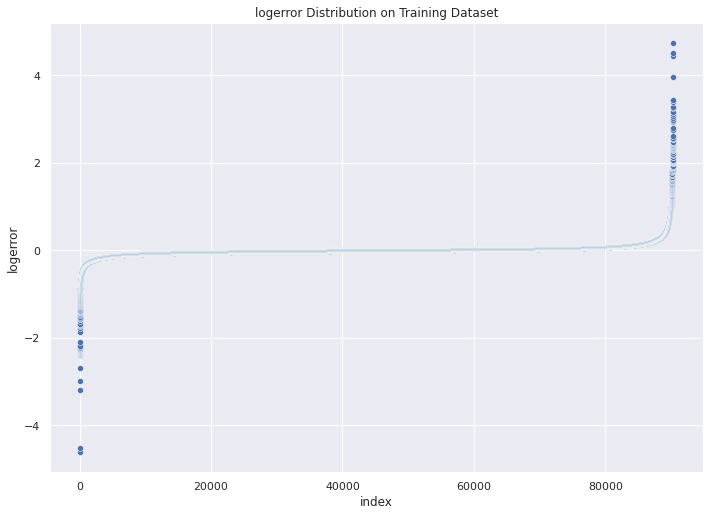

In [4]:
log_error = sorted(train['logerror'].to_list())

ax = sns.scatterplot(x=range(0, len(log_error)), y=log_error, palette = color)
ax.set_title('logerror Distribution on Training Dataset')
ax.set(xlabel = 'index', ylabel = 'logerror')
plt.show()

From this figure we can see that there are some outliers in the target variable. We observed that the outliers are in the range of $<-4$ and $>4$. We should filter out these outliers during training time as our model (XGBoost) is not robust against them. 

### 2.2. Percentage of Missing Values

Now we will see the percentage of missing values for each variable.

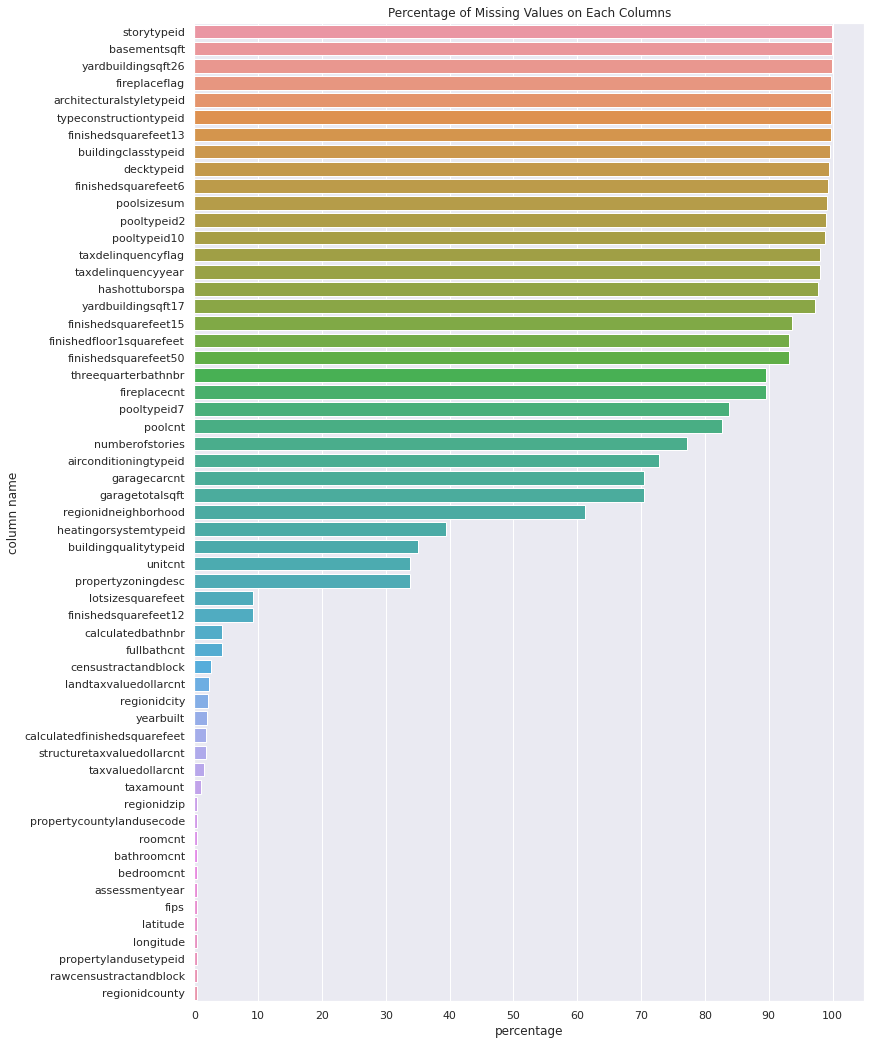

In [5]:
# calculate the percentage of missing values
num_properties = properties.shape[0]
missing_val = properties.isnull().sum()
missing_val = list(zip(missing_val.index, missing_val.to_list())) # convert into list
missing_val = sorted(missing_val, key=lambda x: x[1], reverse=True)

percentage_missing = [(e[0], 100*e[1]/num_properties) for e in missing_val if e[1] > 0]
x_missing = [e[1] for e in percentage_missing]
y_missing = [e[0] for e in percentage_missing]

# create barplot
fig, ax = plt.subplots(figsize=(12,18))
sns.barplot(x=x_missing, y=y_missing, ax=ax)
ax.set_title('Percentage of Missing Values on Each Columns')
ax.set(xlabel='percentage', ylabel='column name')
ax.set_xticks(np.arange(0, 101, 10))
plt.show()

From figure above we can see about 20 variables have more than 90% of missing values. There are several ways to handle this:
* Remove the entire column
* Fill missing columns with some value. It could be default value or statistical value like mean, median, and mode.
* Train machine learning model to predict the missing values
* Utilize external dataset

In this project, we will mostly used the first three options as we are not allowed to use external dataset for public leaderboard. And in the next section we will go through each feature and see the correlation with other features.

### 2.3. Categorical Variables on Training and Test Data

Categorical variables are important features to improve model performance. Therefore, we will see whether there are unseen categorical values especially nominal variable in test data. If the column contains unseen values on test dataset, then we set that values to *nan*.

In [6]:
nominal_cat_columns = ['airconditioningtypeid', 
                       'architecturalstyletypeid', 
                       'buildingclasstypeid',
                       'decktypeid',
                       'heatingorsystemtypeid',
                       'propertycountylandusecode',
                       'propertylandusetypeid',
                       'propertyzoningdesc',
                       'regionidcounty',
                       'regionidcity',
                       'regionidzip',
                       'regionidneighborhood',
                       'storytypeid',
                       'typeconstructiontypeid',
                      ]

df_train = train.merge(properties, how = 'left', on = 'parcelid') 
df_test = test.merge(properties, how = 'left', on = 'parcelid')

for col in nominal_cat_columns:
    unique_train = df_train[col].dropna().unique()
    
    print('Column:', col)
    print('Number of unique categories on training dataset:', len(unique_train))
    print('Number of unique categories on test dataset:', df_test[col].nunique())
    print()
    
    # if data is unseen in training data, convert to nan
    properties.loc[~properties[col].isin(unique_train), col] = np.nan
    
    # convert into categorical data
    properties[col] = properties[col].astype("object")

# delete the dataframes to save up memory
del df_train, df_test
gc.collect();

Column: airconditioningtypeid
Number of unique categories on training dataset: 6
Number of unique categories on test dataset: 7

Column: architecturalstyletypeid
Number of unique categories on training dataset: 6
Number of unique categories on test dataset: 8

Column: buildingclasstypeid
Number of unique categories on training dataset: 1
Number of unique categories on test dataset: 5

Column: decktypeid
Number of unique categories on training dataset: 1
Number of unique categories on test dataset: 1

Column: heatingorsystemtypeid
Number of unique categories on training dataset: 12
Number of unique categories on test dataset: 14

Column: propertycountylandusecode
Number of unique categories on training dataset: 77
Number of unique categories on test dataset: 240

Column: propertylandusetypeid
Number of unique categories on training dataset: 14
Number of unique categories on test dataset: 15

Column: propertyzoningdesc
Number of unique categories on training dataset: 1996
Number of uniqu

### 2.3. Feature Importance

Now we will see each feature significance to our XGBoost model.

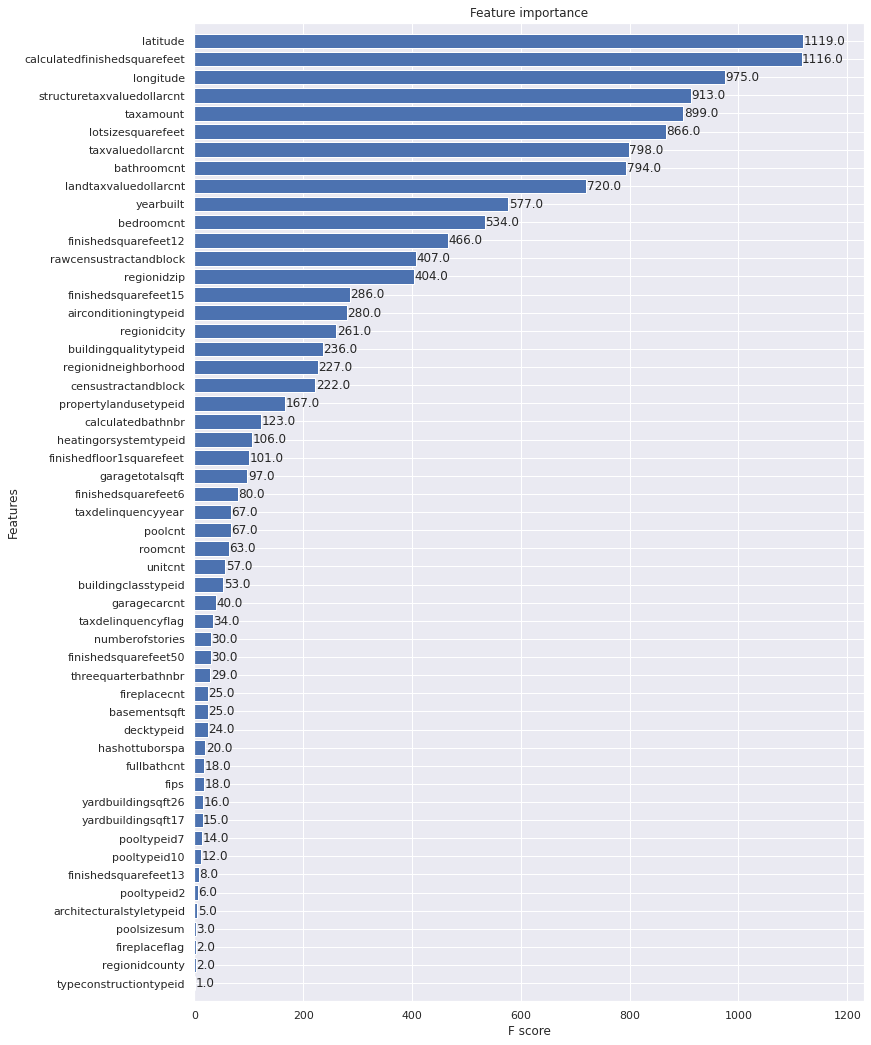

In [7]:
from sklearn.preprocessing import LabelEncoder

# merge training data with properties
df_train = train.merge(properties, how = 'left', on = 'parcelid') 
train_y = df_train['logerror'].values
df_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
feature_names = df_train.columns.values

for c in df_train.columns:
    df_train[c]=df_train[c].fillna(0) # for now, fill nan values with 0
    if df_train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(df_train[c].values))
        df_train[c] = lbl.transform(list(df_train[c].values))

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'seed' : 0
}
dtrain = xgb.DMatrix(df_train, train_y, feature_names=feature_names)
model = xgb.train(dict(xgb_params), dtrain, num_boost_round=150)

# plot the important features 
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=65, height=0.8, ax=ax)
plt.show()

# save up some memory
del df_train
gc.collect();

Above figure shows the significane of each feature. Higher value means the more significant it is to our model. We can see that about half of the features are not very important for our model. We will refer to this graph whenever we decided to remove some features.

## 3. Features Engineering

In this section, we will analyze each feature and see the correlations with the other features. Furthermore, we will modify those feature based on the correlation results. If they have high correlation, we should consider the following:
* Combining those features to create entirely new feature
* Remove some of them as they are redundant features.

We will also recover data for some features based on the relation that we have found. Missing values will be handled on later part.

### 3.1. Bathroom

Bathroom features consist of: 
* `bathroomcnt` 
* `calculatedbathnbr`
* `threequarterbathnbr`
* `fullbathcnt`

We will see the relationship among these features.

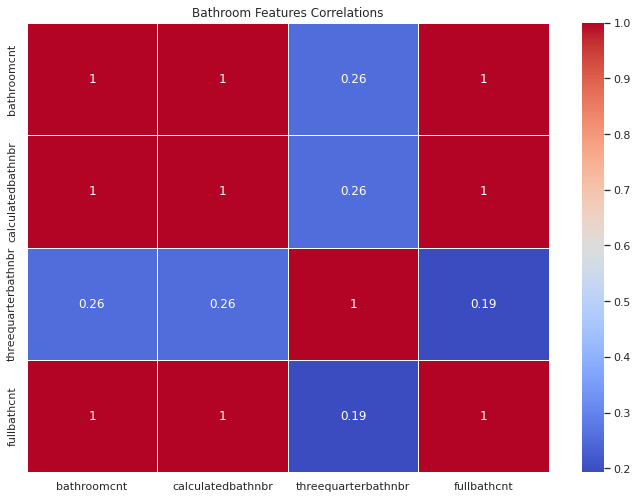

Column calculatedbathnbr
Number of non-null data:  2856305
Number of non-null data that are equal to column bathroomcnt:  2856305

Check whether 'bathroomcnt' = 0.5 * 'threequarterbathnbr' + 'fullbathcnt'
Number of non-null data:  311631
Number of data that satisfied the formula:  311631


In [8]:
# Correlation between bathroom features
bathroom_cols = ['bathroomcnt', 
                 'calculatedbathnbr', 
                 'threequarterbathnbr', 
                 'fullbathcnt']

bathroom_features = properties[bathroom_cols]
bathroom_correlations = bathroom_features.dropna().corr()

ax = sns.heatmap(bathroom_correlations, linewidths = 0.5, annot=True, cmap='coolwarm')
ax.set_title('Bathroom Features Correlations')
plt.show()

# See the relationship between those features
bathroom = properties[bathroom_cols]

# Each non-null value in calculatedbathnbr is equal to the value in bathroomcnt
bath_count = bathroom[bathroom['calculatedbathnbr'].notnull()][['bathroomcnt', 'calculatedbathnbr']]

print("Column calculatedbathnbr")
print("Number of non-null data: ", bath_count.shape[0])
print("Number of non-null data that are equal to column bathroomcnt: ", 
      sum(bath_count['bathroomcnt'] == bath_count['calculatedbathnbr']))

# bathroomcnt = 0.5 * threequarterbathnbr + fullbathcnt
fractional_bath = bathroom[bathroom['threequarterbathnbr'].notnull()][['bathroomcnt', 'threequarterbathnbr', 'fullbathcnt']]

print("\nCheck whether 'bathroomcnt' = 0.5 * 'threequarterbathnbr' + 'fullbathcnt'")
print("Number of non-null data: ", fractional_bath.shape[0])
print("Number of data that satisfied the formula: ", 
     sum(fractional_bath['bathroomcnt'] == (0.5 * fractional_bath['threequarterbathnbr'] + fractional_bath['fullbathcnt'])))

From figure above we can see that `bathroomcnt` is positively correlated to both `calculatedbathnbr` and `fullbathcnt`. In fact, it is easy to check that all of the non-null values of `calculatedbathnbr` are equal to `bathroomcnt`; **`calculatedbathnbr` is redundant feature.** 

In addition to that, we found this relationship: `bathroomcnt` $= 0.5 × $ `threequarterbathnbr` $+$ `fullbathcnt`, which further proves our observation that `bathroomcnt` is positively correlated with `fullbathcnt`. 

Therefore, we modify the features by:
1. Removing columns `fullbathcnt` and `calculatedbathnbr`
2. Recovering data in `threequarterbathnbr` from the relation `bathroomcnt` $= 0.5 × $ `threequarterbathnbr` $+$ `fullbathcnt`

In [9]:
# Recover some data in threequarterbathnbr
properties['threequarterbathnbr'] = 2*(properties['bathroomcnt'] - properties['fullbathcnt'])

# remove unnecessary columns
drop_columns.add('calculatedbathnbr')
drop_columns.add('fullbathcnt')

### 3.2. Finished Squarefeet

This features consist of: 
* `calculatedfinishedsquarefeet` (renamed to `finishedsqft`)
* `finishedfloor1squarefeet`
* `finishedsquarefeet6`
* `finishedsquarefeet12`
* `finishedsquarefeet13`
* `finishedsquarefeet15`
* `finishedsquarefeet50`: subset of `finishedfloor1squarefeet`

From our observation, we found that `finishedsqft` is **union of all the `finishedsquarefeet` (6-50)** features. Therefore, we will remove those features as they are redundant and create new categorical feature named `finishedsqft_categories` that stores which category of each data belongs to (6, 12, 13, 15 or 50). We also create new feature called `num_living_area` $=$ `finishedsqft` $/$ `finishedfloor1squarefeet`.

In [10]:
finished_sqft_cols = [('finishedsquarefeet6', '6'),
                      ('finishedsquarefeet12', '12'),
                      ('finishedsquarefeet13', '13'),
                      ('finishedsquarefeet15', '15'),
                      ('finishedsquarefeet50', '50')]

# rename calculatedfinishedsquarefeet
properties.rename(columns = {'calculatedfinishedsquarefeet':'finishedsqft'}, inplace=True)
properties['finishedsqft_categories'] = np.nan

# create new feature and drop the old ones
for col, category in finished_sqft_cols:
    properties.loc[properties[col].notnull(), 'finishedsqft_categories'] = category
    drop_columns.add(col)
    
# create new feature
properties['num_living_area'] = properties['finishedsqft']/properties['finishedfloor1squarefeet']
drop_columns.add('finishedfloor1squarefeet')

### 3.3. Pool and Hot Tub/Spa

This features consist of:
* `poolcnt`: indicates the number of pools on the lot (if any)
* `poolsizesum`: total area of pools in a property
* `pooltypeid2`: whether pool includes Spa or hot tub
* `pooltypeid7`: whether pool does not include Spa/hot tub
* `pooltypeid10`: whether it is Spa or Hot Tub
* `hashottuborspa`: whether a property has Spa or Hot Tub

We found out that `poolcnt` is union of `pooltypeid2` and `pooltypeid7`. And we also observe that `hashottuborspa` is union of `pooltypeid10` and `pooltypeid2`. Therefore, we will **remove columns with name `pooltypeid`** as they are redundant features.

We decided keep `hashottuborspa`, `poolcnt` and `poolsizesum` as their nan values most likely are equal to 0 (can be interpreted as not having a pool/hot-tub/spa).

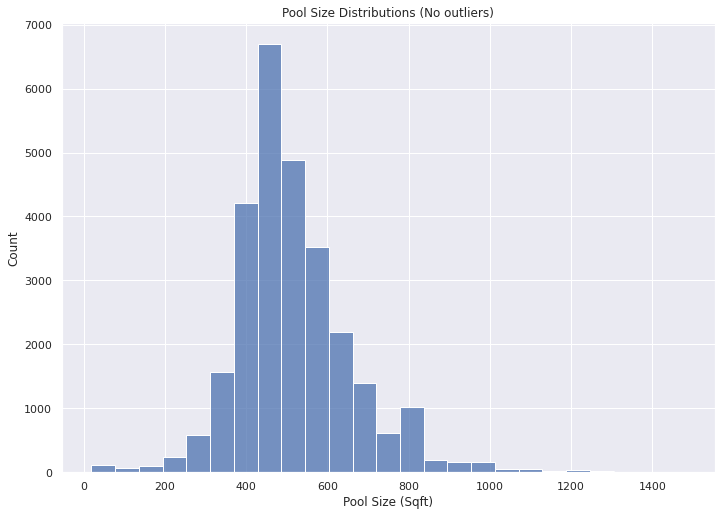

In [11]:
# drop unused columns, remaining features will be used
drop_columns.add('pooltypeid10')
drop_columns.add('pooltypeid2')
drop_columns.add('pooltypeid7')

# plot pool size
pool_size = sorted(properties['poolsizesum'].dropna().tolist())

# filter pool size for visualization
pool_size_vis = [p for p in pool_size if p < 1500]
ax = sns.histplot(data=pool_size_vis, bins=25)
ax.set_title('Pool Size Distributions (No outliers)')
ax.set_xlabel('Pool Size (Sqft)')
plt.show()

From above figure, we can see the distribution of pool size. The plot is skew to the right which means that mean > median. Therefore, we should consider using median for data imputation. 

### 3.4. Garage

This features consist of:
* `garagecarcnt`
* `garagetotalsqft`

We will observe the correlation between these features.

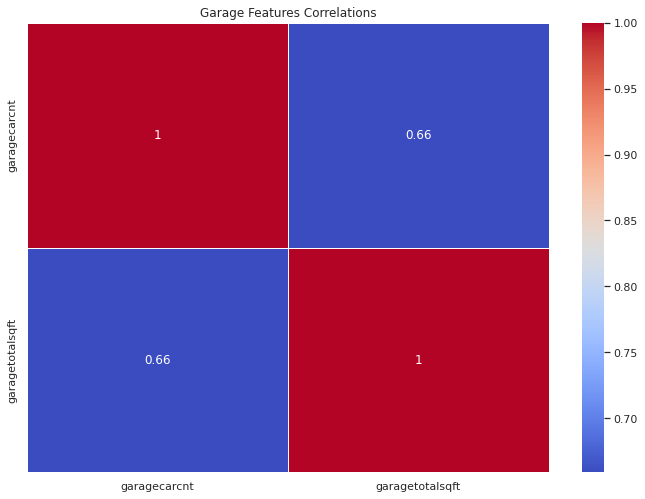

In [12]:
# create correlation matrix
garage_correlation = properties[['garagecarcnt', 'garagetotalsqft']].dropna().corr()
ax = sns.heatmap(garage_correlation, linewidths = 0.5, annot=True, cmap='coolwarm')
ax.set_title('Garage Features Correlations')
plt.show()

From figure above, we can see that both features are highly correlated which suggest that we should remove either `garagecarcnt` or `garagetotalsqft` and create new feature that has lower correlation based on both features. For the implementation we created new feature called `garage_per_sqft` $=$ `garagecarcnt`$/$`garagetotalsqft` and remove `garagecarcnt` as it is less important for our model (please see *Section 2.3*).

In [13]:
# add new features
properties['garage_per_sqft'] = properties['garagecarcnt']/properties['garagetotalsqft']


# drop the columns
drop_columns.add('garagecarcnt')

### 3.5. Yard

This features consist of:
* `yardbuildingsqft17`: Area of patio built in the yard (renamed to `yardpatiosqft`)
* `yardbuildingsqft26`: Area of storage shed built in the yard (renamed to `yardstorageshedsqft`)

Although the features have a lot of missing values, we decided to include this as the value nan most likely equal to zero (interpreted as do not own the properties).

In [14]:
# run this cell only once

print('Number of missing values in column yardbuildingsqft17:', properties['yardbuildingsqft17'].isnull().sum())
print('Number of missing values in column yardbuildingsqft26:', properties['yardbuildingsqft26'].isnull().sum())

# rename the columns
properties.rename(columns = {'yardbuildingsqft17':'yardpatiosqft', 'yardbuildingsqft26':'yardstorageshedsqft'}, inplace=True)

Number of missing values in column yardbuildingsqft17: 2904862
Number of missing values in column yardbuildingsqft26: 2982570


### 3.6. Fireplace

This features consist of:
* `fireplacecnt`: number of fireplaces in a home (if any)
* `fireplaceflag`: whether there is fireplace or not

We will recover the `fireplaceflag` by using threshold `fireplacecnt` $> 0$ and we also keep `fireplacecnt` as nan values likely equal to zero (no fireplace)

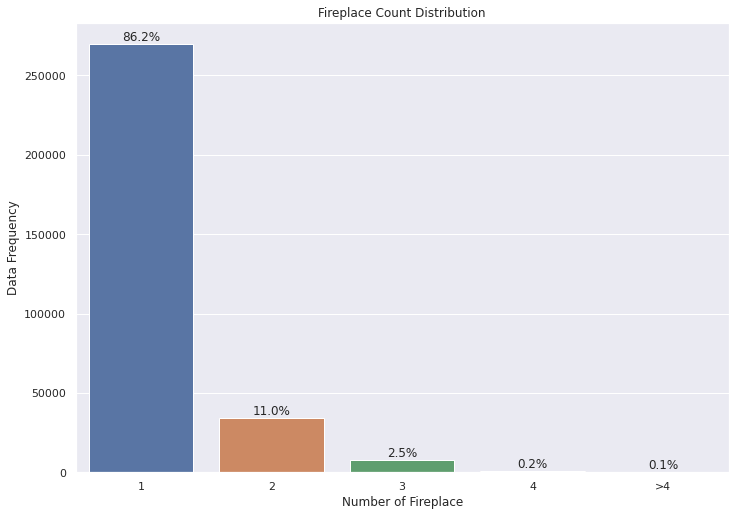

In [15]:
# recover some data of fireplaceflag
properties.loc[properties['fireplacecnt']>0, 'fireplaceflag'] = 1
properties.loc[properties['fireplaceflag'].isnull(), 'fireplacecnt'] = 0

# plot the distribution of fireplacecnt > 0
fireplace = properties[properties['fireplacecnt']>0]['fireplacecnt']
fireplace_count = fireplace.value_counts().sort_index()

x_label = ['1','2','3','4','>4']
y_label = np.append(fireplace_count.values[:4], sum(fireplace_count.values[4:]))

ax = sns.barplot(x=x_label, y=y_label)
patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+2000
    ax.annotate('{:.1f}%'.format(100*y_label[i]/sum(y_label)), (x, y), ha='center')
ax.set_title('Fireplace Count Distribution')
ax.set_xlabel('Number of Fireplace')
ax.set_ylabel('Data Frequency')
plt.show()

# imputation
# flag = 1 -> there is fireplace, update with mean?
# otherwise, update with 0

From above figure, we see that 86% of people owned just one fireplace. This means that we should consider mode for data imputation (if `fireplacecnt` is nan, but `fireplaceflag` is equal to one).

### 3.7 Location

This features consist of:
* `fips`
* `latitude`
* `longitude`
* `regionidcounty`
* `regionidcity`
* `regionidzip`
* `regionidneighborhood`

In [16]:
properties[['fips', 
            'latitude', 
            'longitude', 
            'regionidcounty', 
            'regionidcity', 
            'regionidzip', 
            'regionidneighborhood']].corr()

,fips,latitude,longitude
fips,1.000000,-0.042667,-0.357452
latitude,-0.042667,1.000000,-0.580249
longitude,-0.357452,-0.580249,1.000000


### 3.8. Property Zoning

This features consist of:
* `propertycountylandusecode`: county land use code of the property
* `propertylandusetypeid`: type of land used
* `propertyzoningdesc`: description of the land

All of these features are categorical variables. We observed that there are a lot of *unknown values* in test data (not seen in training dataset). We will set these unknown values to *nan*.

In [17]:
# # training & test dataset
# df_train = train.merge(properties, how = 'left', on = 'parcelid') 
# df_test = test.merge(properties, how = 'left', on = 'parcelid')

# prop_zoning_cols = ['propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc']

# for col in prop_zoning_cols:
#     unique_train = df_train[col].dropna().unique()
    
#     print('Column:', col)
#     print('Number of unique categories on training dataset:', len(unique_train))
#     print('Number of unique categories on test dataset:', df_test[col].nunique())
#     print()
    
#     # if data is unseen in training data, convert to nan
#     properties.loc[~properties[col].isin(unique_train), col] = np.nan
    
#     # convert into categorical data
#     properties[col] = properties[col].astype("object")

# # delete the dataframes to save up memory
# del df_train, df_test
# gc.collect();

In [18]:
#

### 3.9. Other Features

This section will mention about features that have too many missing values and harder to interpret the meaning of those nan values. Most of these features will either be removed or imputed to zero as default value.

#### Aircon Type ID (`airconditioningtypeid`)

This feature has about 70% missing values and 13 categories. The nan values can hold several meaning: *missing*, *none*, or *other*. Since *none* and *other* are denoted as ID number 5 and 6 respectively (see data dictionary downloaded from kaggle Zillow Prize), we categorized nan as new category ID number 0.

In [23]:
# aircon type
aircon_id_dict = {
    1:'Central',
    2:'Chilled Water',
    3:'Evaporative Cooler',
    4:'Geo Thermal',
    5:'None',
    6:'Other',
    7:'Packaged AC Unit',
    8:'Partial',
    9:'Refrigeration',
    10:'Ventilation',
    11:'Wall Unit',
    12:'Window Unit',
    13:'Yes'
}

total_count = properties['airconditioningtypeid'].dropna().shape[0]
aircon_dist = properties['airconditioningtypeid'].value_counts().sort_index()
aircon_df = aircon_dist.to_frame()

aircon_df['aircon_id'] = aircon_df.index.astype(int)
aircon_df['aircon_type'] = [aircon_id_dict[i] for i in aircon_df['aircon_id'].values]
aircon_df.reset_index(drop=True, inplace=True)
aircon_df.rename(columns={'airconditioningtypeid':'frequency'}, inplace=True)
aircon_df['percentage'] = aircon_df['frequency'] / total_count * 100

# reorder the table
aircon_df = aircon_df[['aircon_id','aircon_type', 'frequency', 'percentage']]
aircon_df.style.set_caption('Aircon-Type Data Distributions').set_table_styles([{
    'selector': 'caption',
    'props': [('text-align', 'center')]
}])

,aircon_id,aircon_type,frequency,percentage
0,1,Central,742364,91.484978
1,3,Evaporative Cooler,7,0.000863
2,5,None,8795,1.083849
3,9,Refrigeration,19,0.002341
4,11,Wall Unit,1818,0.224041
5,13,Yes,58457,7.203929


#### Architectural Style ID (`architecturalstyletypeid`)

This feature consists of 99% missing values and 27 categories. In *Section 2.3* we see that this feature is not important to our model even after performing data imputation. Therefore, we decided to remove this feature.

In [24]:
# remove the feature
drop_columns.add('architecturalstyletypeid')

# architectural style
archi_id_dict = {
    1:'A-Frame',
    2:'Bungalow',
    3:'Cape Cod',
    4:'Cottage',
    5:'Colonial',
    6:'Custom',
    7:'Contemporary',
    8:'Conventional',
    9:'Dome',
    10:'French Provincial',
    11:'Georgian',
    12:'High Rise',
    13:'Historical',
    14:'Log Cabin/Rustic',
    15:'Mediterranean',
    16:'Modern',
    17:'Mansion',
    18:'English',
    19:'Other',
    20:'Prefab',
    21:'Ranch/Rambler',
    22:'Raised Ranch',
    23:'Spanish',
    24:'Traditional',
    25:'Tudor',
    26:'Unfinished/Under Construction',
    27:'Victorian'
}

total_count = properties['architecturalstyletypeid'].dropna().shape[0]
archi_style = properties['architecturalstyletypeid'].value_counts().sort_index()
archi_df = archi_style.to_frame()

archi_df['style_id'] = archi_df.index.astype(int)
archi_df['architecture_type'] = [archi_id_dict[i] for i in archi_df['style_id'].values]
archi_df.reset_index(drop=True, inplace=True)
archi_df.rename(columns={'architecturalstyletypeid':'frequency'}, inplace=True)
archi_df['percentage'] = archi_df['frequency'] / total_count * 100

# reorder the table
archi_df = archi_df[['style_id', 'architecture_type', 'frequency', 'percentage']]
archi_df.style.set_caption('Architectural-Style Frequency Distributions').set_table_styles([{
    'selector': 'caption',
    'props': [('text-align', 'center')]
}])

,style_id,architecture_type,frequency,percentage
0,2,Bungalow,201,3.327264
1,3,Cape Cod,58,0.960106
2,7,Contemporary,5251,86.922695
3,8,Conventional,380,6.290349
4,10,French Provincial,1,0.016554
5,21,Ranch/Rambler,150,2.483033


#### Basement (`basementsqft`)

This feature has numerical values and about 99% of values are missing. We will keep this feature by interpreting the nan values as not having a basement (they will be filled with zero).

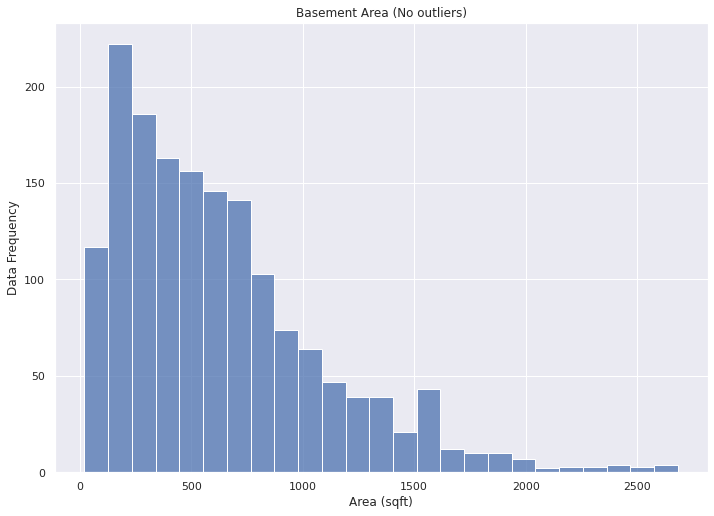

In [26]:
basement_area = sorted(properties['basementsqft'].dropna().tolist())
basement_area_vis = [b for b in basement_area if b < 3000]

# visualization for non null values
ax = sns.histplot(data=basement_area_vis, bins=25)
ax.set_title('Basement Area (No outliers)')
ax.set_xlabel('Area (sqft)')
ax.set_ylabel('Data Frequency')
plt.show()

# The distribution is skewed to the right (long right tail) 

#### Bedroom (`bedroomcnt`)

This feature have multiple meanings for nan values, it could be interpreted as *missing data* or *does not have bedroom*. If it means missing data, we should impute it with mean, median, or machine learning model predictions. Otherwise, we should impute it with zero.

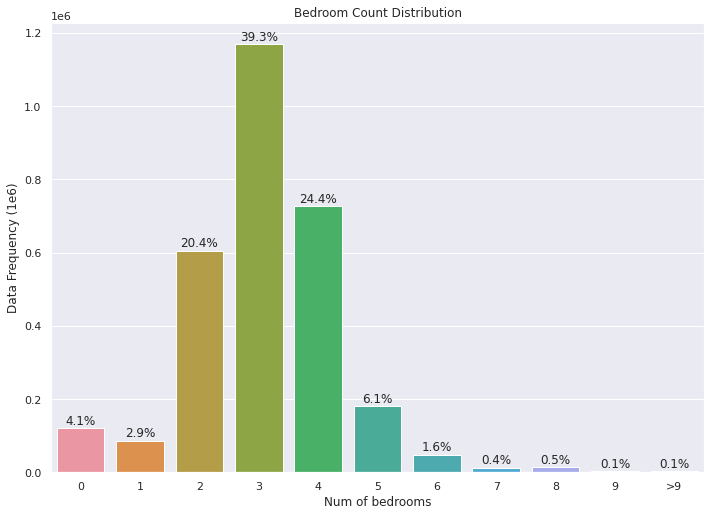

In [27]:
bedroom_lt10 = properties.loc[properties['bedroomcnt'] < 10, 'bedroomcnt']
bedroom_gt10 = properties.loc[properties['bedroomcnt'] >= 10, 'bedroomcnt']
num_bedroom_gt10 = bedroom_gt10.count()
bedroom_dist = bedroom_lt10.value_counts().sort_index()

# plot the distributions 
x_label = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '>9']
y_label = np.append(bedroom_dist.values, num_bedroom_gt10)

ax = sns.barplot(x=x_label, y=y_label)
patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+10000
    ax.annotate('{:.1f}%'.format(100*y_label[i]/sum(y_label)), (x, y), ha='center')
ax.set_title('Bedroom Count Distribution')
ax.set_xlabel('Num of bedrooms')
ax.set_ylabel('Data Frequency (1e6)')
plt.show()

From above figure, we see that the plot is actually similar to standard normal distribution curve. This means that $mean ≈ median$ and we could choose any of them for data imputation.

#### Building Quality (`buildingqualitytypeid`)

This feature has ordinal variable from $1-12$ with $1$ denoted as highest quality and $12$ as lowest quality. Therefore, we imputing the missing values with zero may not be the best solution and should consider using mean or median instead.

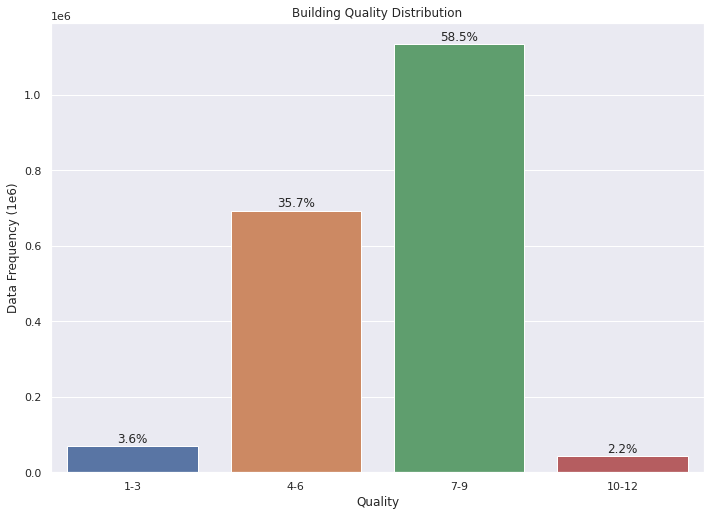

In [28]:
building_quality_dist = properties['buildingqualitytypeid'].dropna().value_counts().sort_index()
bins = np.array_split(building_quality_dist, 4)

# discretize into four bins for visualization
x_label = [f'{i}-{i+2}' for i in range(1,13,3)]
y_label = []
prev_val = 0

for b in bins:
    y_label.append(sum(b)-prev_val)
    prev_val = b.tolist()[-1]

# plot visualization
ax = sns.barplot(x=x_label, y=y_label)
patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+10000
    ax.annotate('{:.1f}%'.format(100*y_label[i]/sum(y_label)), (x, y), ha='center')
ax.set_title('Building Quality Distribution')
ax.set_xlabel('Quality')
ax.set_ylabel('Data Frequency (1e6)')
plt.show()

#### Building Class (`buildingclasstypeid`)

This feature is nominal variable and more than 95% of data are missing. After we replace unseen variable on test data with *nan*, we will get one unique non-null value. Therefore, we will remove this column.

In [34]:
properties['buildingclasstypeid'].dropna().unique()

drop_columns.add('buildingclasstypeid')

#### Deck (`decktypeid`)

This feature only have one non-null unique value. Therefore, we will impute this with zero.

In [35]:
properties['decktypeid'].dropna().unique()

# drop column
drop_columns.add('decktypeid')

#### Heating System (`heatingorsystemtypeid`)

This feature consists nominal variable with $25$ possible values. We will consider to impute the missing data with mode or zero.

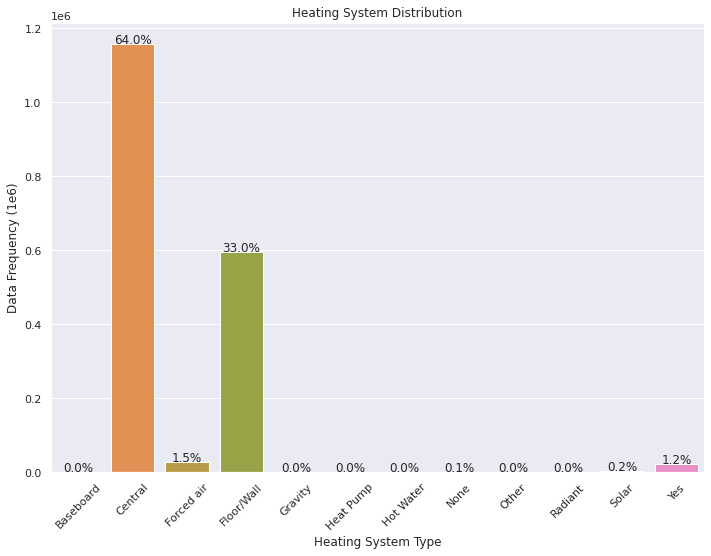

In [36]:
# heating/system type id
heating_id_dict = {
    1: 'Baseboard',
    2: 'Central',
    3:'Coal',
    4:'Convection',
    5:'Electric',
    6:'Forced air',
    7:'Floor/Wall',
    8:'Gas',
    9:'Geo Thermal',
    10:'Gravity',
    11:'Heat Pump',
    12:'Hot Water',
    13:'None',
    14:'Other',
    15:'Oil',
    16:'Partial',
    17:'Propane',
    18:'Radiant',
    19:'Steam',
    20:'Solar',
    21:'Space/Suspended',
    22:'Vent',
    23:'Wood Burning',
    24:'Yes',
    25:'Zone'
}

heating_system = properties['heatingorsystemtypeid'].value_counts().sort_index()
x_label = [heating_id_dict[i] for i in heating_system.index]
y_label = heating_system.values

ax = sns.barplot(x=x_label, y=y_label)
patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+2000
    ax.annotate('{:.1f}%'.format(100*y_label[i]/sum(y_label)), (x, y), ha='center')
ax.set_title('Heating System Distribution')
ax.set_xlabel('Heating System Type')
ax.set_ylabel('Data Frequency (1e6)')
ax.tick_params(axis='x', rotation=45)
plt.show()

#### Lot Size (`lotsizesquarefeet`)

This feature is represented by numerical data and the value is very likely to be greater than 0. Therefore, we should consider the mean and median for data imputation.

Number of non null values: 2709118
Percentage area > 50000: 6.519649568604985 %


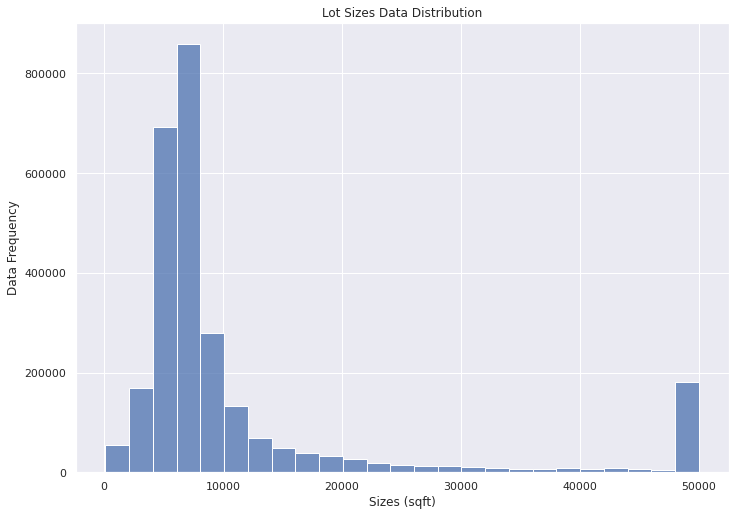

In [37]:
# lot size squarefeet
lot = sorted(properties['lotsizesquarefeet'].dropna().tolist())
print("Number of non null values:", len(lot))
lot_vis = [b if b < 50000 else 50000 for b in lot]
gt_50k = [b for b in lot if b >= 50000]
print("Percentage area > 50000:", len(gt_50k)/len(lot)*100, "%")

ax = sns.histplot(data=lot_vis, bins=25)
ax.set_title('Lot Sizes Data Distribution')
ax.set_xlabel('Sizes (sqft)')
ax.set_ylabel('Data Frequency')
plt.show()

As we can see in figure above, the distribution follows long tail distribution. And the graph is skew to the right which means that we should use median for data imputation. 

#### Story (`storytypeid` and `numberofstories`)

`storytypeid` only consists of unique value and more than 99% of the data are missing. These null values could mean that no property named story or people do not know which category their story belongs to. **Our assumption is that null means no property**, so we will do the following:

* The null value in `numberofstories` will be set to zero.
* Consequently, we remove `storytypeid` as it will no longer hold any meaning.

In [38]:
# see the non-null value(s) of the storytypeid
print("Number of data with non-null values: ", properties['storytypeid'].notnull().sum())
print("Non-null values:" ,properties['storytypeid'].dropna().unique()) # only have value 7

# drop column
drop_columns.add('storytypeid')

Number of data with non-null values:  1624
Non-null values: [7.0]


#### Construction Type (`typeconstructiontypeid`)

This feature consists of nominal variable and more than 99% of the data are missing. Based on *Section 2.3*, this feature is not important for our model so we decided to remove it.

In [39]:
# percentage missing value
missing_val = properties['typeconstructiontypeid'].isnull().sum()
print("Percentage of missing values:", 100*missing_val/properties.shape[0], "%")

drop_columns.add('typeconstructiontypeid')

Percentage of missing values: 99.77412027333357 %


In [40]:
drop_columns

{'architecturalstyletypeid',
 'buildingclasstypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fullbathcnt',
 'garagecarcnt',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'storytypeid',
 'typeconstructiontypeid'}

## 4. Further Preprocessing

In this section we will add more features that haven't been mentioned on previous section.

### 4.1. Adding More Features

In [41]:
#living area proportions 
properties['living_area_prop'] = properties['finishedsqft'] / properties['lotsizesquarefeet']

#tax value ratio
properties['value_ratio'] = properties['taxvaluedollarcnt'] / properties['taxamount']

#tax value proportions
properties['value_prop'] = properties['structuretaxvaluedollarcnt'] / properties['landtaxvaluedollarcnt']

properties['N-TotalRooms'] = properties['bathroomcnt']*properties['bedroomcnt']

properties['N-AvRoomSize'] = properties['finishedsqft']/properties['roomcnt'] 

properties['N-ExtraRooms'] = properties['roomcnt'] - properties['N-TotalRooms']

properties["N-location"] = properties["latitude"] + properties["longitude"]

# time features
def add_time_features(df):
    df["transaction_year"] = pd.to_numeric(df['transactiondate'].dt.year)
    df["transaction_month"] = (df['transactiondate'].dt.year - 2016)*12 + df["transactiondate"].dt.month
    df["transaction_day"] = df['transactiondate'].dt.day
    df["transaction_quarter"] = (df['transactiondate'].dt.year - 2016)*4 +df["transactiondate"].dt.quarter
    
    return df

### 4.2. Handling Missing Values

In [42]:
df_train = train.merge(properties, how = 'left', on = 'parcelid') 
df_test = test.merge(properties, how = 'left', on = 'parcelid')

# add time features
df_train = add_time_features(df_train)
df_test['transactiondate'] = pd.Timestamp('2016-12-01')
df_test = add_time_features(df_test)

# remove unused variables
del properties, train
gc.collect()

# drop columns

df_train = df_train.drop(drop_columns, axis=1)
df_test = df_test.drop(drop_columns, axis=1)

# normalize very big data
df_train[['latitude', 'longitude']] /= 1e6
df_test[['latitude', 'longitude']] /= 1e6

df_train['censustractandblock'] /= 1e12
df_test['censustractandblock'] /= 1e12

# Handling missing values
# Replace inf with nan
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# median imputer
from sklearn.impute import SimpleImputer

median_cols = ['num_living_area', 'finishedsqft', 'buildingqualitytypeid', 'lotsizesquarefeet']
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df_train[median_cols] = median_imputer.fit_transform(df_train[median_cols])
df_test[median_cols] = median_imputer.transform(df_test[median_cols]) # do not fit into test data

# fill nan with zero
from sklearn.preprocessing import LabelEncoder  

lbl = LabelEncoder()
for c in df_train.columns:
    df_train[c]=df_train[c].fillna(0)
    if df_train[c].dtype == 'object':
        lbl.fit(list(df_train[c].values))
        df_train[c] = lbl.transform(list(df_train[c].values))

for c in df_test.columns:
    df_test[c]=df_test[c].fillna(0)
    if df_test[c].dtype == 'object':
        lbl.fit(list(df_test[c].values))
        df_test[c] = lbl.transform(list(df_test[c].values))

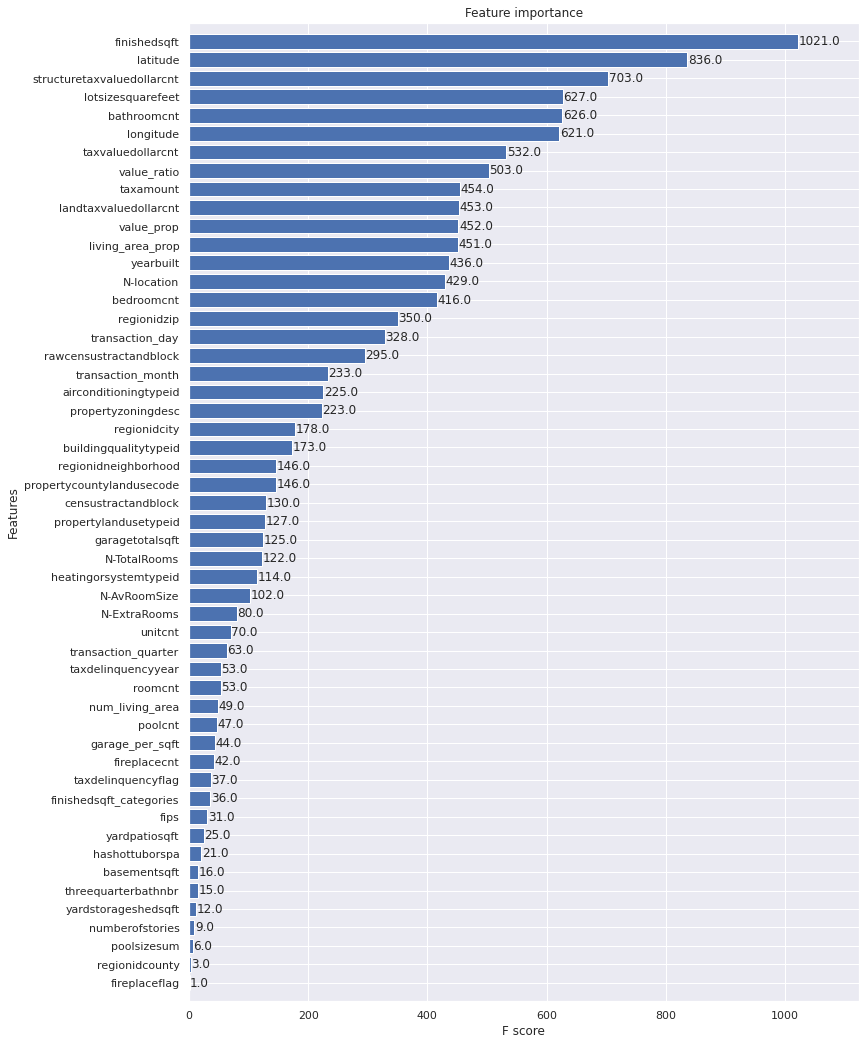

In [43]:
# remove unnecessary columns
x_train = df_train.drop(['parcelid', 
                         'logerror', 
                         'transactiondate'], axis=1)
#                          'propertyzoningdesc', 
#                          'propertycountylandusecode'], axis=1)
y_train = df_train['logerror'].values

x_test = df_test.drop(['parcelid', 'transactiondate',#'propertyzoningdesc', 'propertycountylandusecode',
                       '201610', '201611', '201612', '201710', '201711', '201712'],
                      axis = 1) 

# statistical test
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'seed' : 0
}
dtrain = xgb.DMatrix(x_train, y_train, feature_names=x_train.columns.values)
model = xgb.train(dict(xgb_params), dtrain, num_boost_round=150)

# plot the important features 
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=65, height=0.8, ax=ax)
plt.show()

In [47]:
# drop low score columns
low_score_cols = ['fireplaceflag', 
                  'regionidcounty', 
                  'poolsizesum', 
                  'numberofstories', 
                  'yardstorageshedsqft',
                  'threequarterbathnbr',
                  'basementsqft'
                 ]

x_train = x_train.drop(low_score_cols, axis=1)
x_test = x_test.drop(low_score_cols, axis=1)

In [48]:
# save processed data to csv
x_train['logerror'] = y_train

print("Saving the processed data ...")
x_train.to_csv('../dataset/processed/train_data.csv', index = False)
x_test.to_csv('../dataset/processed/test_data.csv', index = False)
print("Finished writing the file")

Saving the processed data ...
Finished writing the file
